It has been observed in prior work that tasks sharing some underlying structure will exhibit overlapping neural activity. For instance, Yang et. al. (2019) trained RNNs on several cognitive tasks and observed clustering in the neural activity space: some clusters specialized to particular tasks, while others were shared between tasks. In theory, it is also possible to observe a completely distributed representation (i.e. no modular clusters). While Yang focused on sensory tasks, we aim to study tasks involving abstract relations: transitive inference, subset inclusion, and divisibility. These tasks are likely to have some common underlying structure, as both represent transitive relations. We will compare the neural geometry of the same model trained on one of these tasks at a time to that trained on both (using interleaving).

Finally, we will train an RNN on a secondary task requiring the representations learned in the transitive inference task. While we have not finalized this task, its purpose is to generate interesting dynamics. One example may be: At each time step, a new item (from the items learned during the TI task) will be presented to the RNN. Its task will be to output the items it has seen so far in the correct order at each time step. Another idea is to show the RNN two inputs at each time step and to morph one of the inputs until the relationship between the inputs is flipped (for example, if the first input is ‘greater’, then ‘shrink’ it until the second input is ‘greater’, where the notion of ‘greater than’ is relative to the task). The RNN’s task would be to return 0 while the original relation holds, and 1 once it no longer holds.

Questions we hope to answer: How will the neural representation of a given task change when more than one task is learned simultaneously? In the latter case, will we find that the activations shared between the two tasks are also present in some form when only one task is learned at a time? That is—does a neural network organize its activity differently when related tasks must be learned together? We will use RDM analysis and dimensionality reduction techniques to look for specialized clusters in neural activity space. We will then compare our networks using RSA/RDA, as well as dynamics-based methods such as DSA and fixed/slow point analysis.

In [2]:
# Transitive Inference: (i.e. index 0 is greater than index 1 = "A > B")
# Example stimulus: [[1, 0, 0],[0, 1, 0]]
# Example output: 0

# Subset Inclusion: (i.e. index 0 is greater than index 1 = "A \contains B")
# Example stimulus: [[1, 1, 1],[0, 1, 0]]
# Example output: 0 = "A \contains B"

# Divisibility:
# Example stimulus: [6,3]
# Example output: 0 = "A is divisble by B"

In [3]:
# @title Imports

# General
import numpy as np
#import pandas as pd
#from scipy.stats import zscore
#import matplotlib as mpl
from matplotlib import pyplot as plt
import random
from statistics import mean
#import math
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import itertools

# Deep learning
import torch
from torch import nn, optim

# Sklearn
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
# # Response visualizations
# !pip install umap-learn
# import umap
#import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)



In [13]:
# @title Helper functions

def plot_rdms(model, inputs):
  model.eval()

  # Dictionary to store the features
  features = {}

  # Hook to capture the output of each layer
  def get_features(name):
      def hook(model, input, output):
          features[name] = output.detach()
      return hook

  # Register hooks for each layer
  for name, layer in model.named_modules():
      if isinstance(layer, (nn.Linear, nn.Sigmoid)):
          layer.register_forward_hook(get_features(name))

  # Pass the inputs through the model
  t_stimulus = torch.tensor(inputs, dtype=torch.float)
  with torch.no_grad():
      _ = model(t_stimulus)

  # Compute RDMs for each layer
  rdms = {}
  for layer_name, activations in features.items():
      activations = activations.numpy()
      distances = pdist(activations, metric='euclidean')
      rdm = squareform(distances)
      rdms[layer_name] = rdm

  # Flatten each RDM into a vector
  flattened_rdms = {layer_name: rdm.flatten() for layer_name, rdm in rdms.items()}

  # Compute pairwise dissimilarities between these vectors
  rdm_vectors = np.array(list(flattened_rdms.values()))
  rdm_dissimilarities = pdist(rdm_vectors, metric='euclidean')

  # Construct the RDM of RDMs
  rdm_of_rdms = squareform(rdm_dissimilarities)

  # Plot the RDMs of each layer
  num_layers = len(rdms)
  fig, axes = plt.subplots(1, num_layers + 1, figsize=(20, 5))

  for ax, (layer_name, rdm) in zip(axes, rdms.items()):
      sns.heatmap(rdm, ax=ax, cmap='viridis', xticklabels=False, yticklabels=False)
      ax.set_title(layer_name)
      ax.set_xlabel('Samples')
      ax.set_ylabel('Samples')

  # Plot the RDM of RDMs
  sns.heatmap(rdm_of_rdms, ax=axes[-1], cmap='viridis', xticklabels=flattened_rdms.keys(), yticklabels=flattened_rdms.keys())
  axes[-1].set_title('RDM of RDMs')
  axes[-1].set_xlabel('Layers')
  axes[-1].set_ylabel('Layers')

  plt.suptitle('RDMs of Each Layer')
  plt.tight_layout()
  plt.show()

In [5]:
# @title Data generation (Feedforward)

def make_stimulus_dict(input_length, task='ti'):
    stimulus_order_dict = []

    if task == 'ti':
      for index in range(input_length):
        stimulus_key = [0]*input_length
        stimulus_key[index] = 1
        stimulus_order_dict.append(stimulus_key)
      random.shuffle(stimulus_order_dict)

    # elif task == "si":
    #   for index in range(input_length):
    #     stimulus_key = [0]*input_length


    return stimulus_order_dict

In [6]:
params_dict_TI = {
    'batch_size': 10,
    'n_epochs': 200,
    'dataset_size': 1000,
    'learning_rate': 0.0005,
    'momentum': .99,
    'task': 'ti',
    'input_length': 10
}

In [7]:
params_dict_SI = {
    'batch_size': 10,
    'n_epochs': 200,
    'dataset_size': 1000,
    'learning_rate': 0.0005,
    'momentum': .99,
    'task': 'si',
    'input_length': 10
}

In [8]:
# @title Architecture: Feedforward

# Inputs: list of two vectors
# Outputs: scalar (0/1)

# Helpers
def get_resp_layer_labels(net):
  layer_names = list(net._modules.keys())
  return layer_names

def get_resp_layer_inputs(task='ti', stimulus_dict=None):
  if task == 'ti':
    return stimulus_dict

class Feedforward(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Feedforward, self).__init__()
    self.fc1 = nn.Linear(input_dim*2, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()
    # self.relu = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.fc1(x)
    # x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x.squeeze()

  def predict(self, x):
    with torch.no_grad():
      return torch.relu(self.forward(x))

  def evaluate(self, dataset_size, task='ti', stimulus_dict=None):
    with torch.no_grad():
      test_stimuli, test_labels = get_batch(params_dict['dataset_size'], task, stimulus_dict, mode='test')
      loss_fn = nn.BCELoss()

      track_loss = []
      for i in range(params_dict['dataset_size']//params_dict['batch_size']):
        out = self.forward(test_stimuli)
        loss = loss_fn(out, test_labels)
        track_loss.append(loss.item())

      return mean(track_loss)

In [9]:
# @title Data generation (Feedforward)

def make_stimulus_dict(input_length, task='ti'):
    stimulus_order_dict = []

    if task == 'ti':
      for index in range(input_length):
        stimulus_key = [0]*input_length
        stimulus_key[index] = 1
        stimulus_order_dict.append(stimulus_key)
      random.shuffle(stimulus_order_dict)

    # elif task == "si":
    #   for index in range(input_length):
    #     stimulus_key = [0]*input_length


    return stimulus_order_dict

def get_batch(batch_size, task, stimulus_dict=None, input_length=3, mode='train'):

  # Helpers
  def get_binary_vec(input_length):
    return [random.randint(0, 1) for _ in range(input_length)]

  def make_stimulus(input_length, task='ti'):
    if task == 'ti':
      if mode == 'test':
        dict_indices = [0,0]
        while abs(dict_indices[0] - dict_indices[1]) < 2:
          dict_indices = random.sample(range(input_length), 2)
          random.shuffle(dict_indices)
      elif mode == 'train':
        temp_idx = random.sample(range(input_length-1), 1)
        dict_indices = [temp_idx[0], temp_idx[0]+1]
        random.shuffle(dict_indices)

      stimulus = [stimulus_dict[i] for i in dict_indices]

      if dict_indices[0] < dict_indices[1]: # If the first item is greater, it appears earlier in the list
        target = 0
      else:
        target = 1

    elif task == 'si':
      stimulus = [0,0]
      if mode == 'test':
        # while stimulus[0] == stimulus[1]:
        #   stimulus = [get_binary_vec(input_length), get_binary_vec(input_length)]
        first_vec = get_binary_vec(input_length)
        while stimulus[0] == stimulus[1]:
          temp_indices = random.sample(range(input_length), random.randint(2, input_length))
          second_vec = first_vec.copy()
          for i in temp_indices:
            if second_vec[i] == 1:
              second_vec[i] = 0
            # else:
            #   second_vec[i] = 1
          stimulus = [first_vec, second_vec]
      elif mode == 'train':
        first_vec = get_binary_vec(input_length)
        temp_idx = random.sample(range(input_length), 1)
        second_vec = first_vec.copy()
        while stimulus[0] == stimulus[1]:
          if second_vec[temp_idx[0]] == 1:
            second_vec[temp_idx[0]] = 0
          else:
            second_vec[temp_idx[0]] = 1
          stimulus = [first_vec, second_vec]

      random.shuffle(stimulus)
      if stimulus[0] > stimulus[1]: # If first binary number is greater, it is the superset
        target = 0
      else:
        target = 1

    # elif task == "div":
    #   stimulus = [random.sample(range(0, 100, 2),1)[0], random.sample(range(0, 100, 2),1)[0]]
    #   if stimulus[0] % stimulus[1] == 0:
    #     target = 0
    #   else:
    #     target = 1

    return stimulus, target

  stimuli = []
  labels = []
  for _ in range(batch_size):
    stimulus, target = make_stimulus(input_length, task)
    stimuli.append(stimulus)
    labels.append(target)

  stimuli = torch.tensor(stimuli).float()
  labels = torch.tensor(labels).float()

  if torch.cuda.is_available():
    stimuli = stimuli.to('cuda')
    labels = labels.to('cuda')

  return stimuli, labels

def get_RDM_stims_SI(num_samples, input_length=10):

  # Helpers
  def get_binary_vec(input_length):
    return [random.randint(0, 1) for _ in range(input_length)]

  def make_stimulus(input_length):
    first_vec = get_binary_vec(input_length)
    temp_indices = random.sample(range(input_length), random.randint(0, input_length))
    second_vec = first_vec.copy()
    for i in temp_indices:
      if second_vec[i] == 1:
        second_vec[i] = 0
    stimulus = [first_vec, second_vec]
    random.shuffle(stimulus)
    if stimulus[0] > stimulus[1]: # If first binary number is greater, it is the superset
      target = 0
    else:
      target = 1

    return stimulus, target

  stimuli = []
  labels = []
  for _ in range(num_samples):
    stimulus, target = make_stimulus(input_length)
    stimuli.append(stimulus)
    labels.append(target)

  stimuli = torch.tensor(stimuli).float()
  labels = torch.tensor(labels).float()

  if torch.cuda.is_available():
    stimuli = stimuli.to('cuda')
    labels = labels.to('cuda')

  return stimuli, labels

In [10]:
input_length = 10
stimulus_dict = make_stimulus_dict(input_length)
#print(stimulus_dict,'\n')
stimulus_SI = get_batch(100, 'si', stimulus_dict, input_length, mode='test')

In [11]:
#@title Load the saved Feedforward model.
from google.colab import drive
drive.mount('/content/drive/')
!cp 'drive/MyDrive/Neuromatch/ff_10_weights_TI' '/content/ff_10_weights_TI'
!cp 'drive/MyDrive/Neuromatch/ff_10_weights_TI' '/content/ff_10_weights_SI'

model_TI = Feedforward(input_dim=params_dict_TI['input_length'], hidden_dim=10, output_dim=1)
model_TI.load_state_dict(torch.load('/content/ff_10_weights_TI'))

model_SI = Feedforward(input_dim=params_dict_SI['input_length'], hidden_dim=10, output_dim=1)
model_SI.load_state_dict(torch.load('/content/ff_10_weights_SI'))

Mounted at /content/drive/


<All keys matched successfully>

# Representational similarity

## RDMs

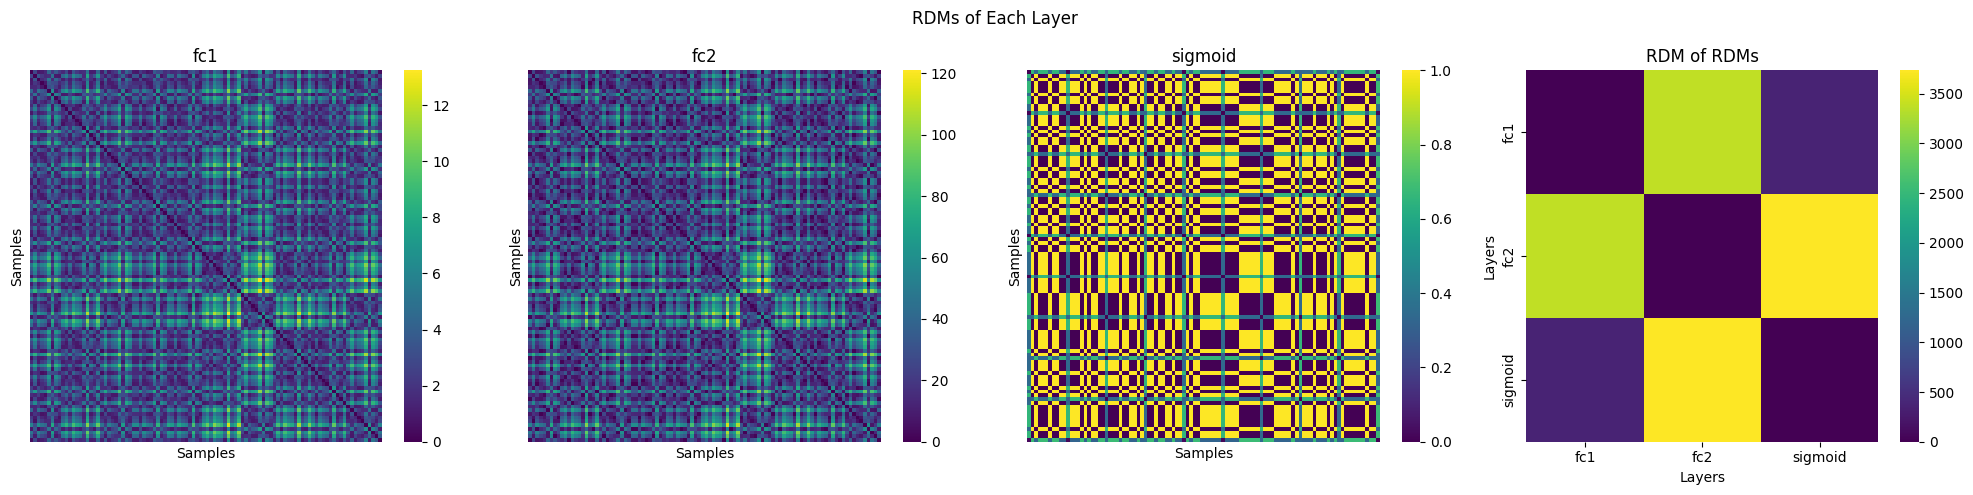

In [14]:
# @title RDMs for TI model

# Create stimulus as test data
stimulus_dict_TI = make_stimulus_dict(params_dict_TI['input_length'])
stimulus_TI = list(itertools.product(stimulus_dict_TI, repeat=2))
plot_rdms(model_TI, stimulus_TI)

<ipython-input-13-cf02c60f2db3>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_stimulus = torch.tensor(inputs, dtype=torch.float)


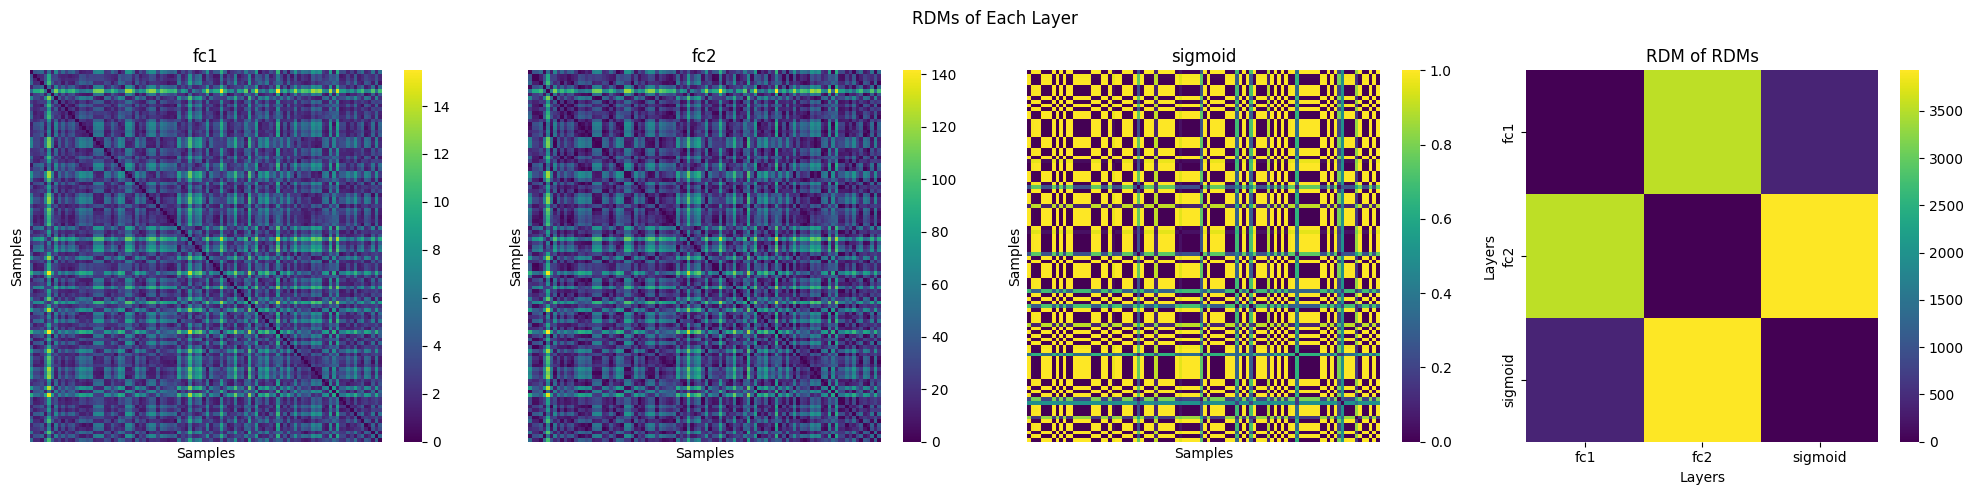

In [15]:
# @title RDMs for SI model

plot_rdms(model_SI, stimulus_SI[0])

## Representation clustering